# Labelling using Shannon-Entropy

In [4]:
from skimage import io
from skimage.measure import shannon_entropy

def preference_function(image_1_path, image_2_path):
    image_1 = io.imread(image_1_path, as_gray=True)
    image_2 = io.imread(image_2_path, as_gray=True)

    entropy_1 = shannon_entropy(image_1)
    entropy_2 = shannon_entropy(image_2)

    return 1 if entropy_1 > entropy_2 else 0


In [5]:
preference_function("../../dataset/img0.png", "../../dataset/img1.png")

0

# Generating Pairs of Dataset 

## Reduce 5550 img dataset size to 1% ~ 55

In [6]:
import os
import random
import shutil

# Paths
original_folder = "../../dataset"
new_folder = "../one_percent_dataset"

# Create the new folder if it doesn't exist
os.makedirs(new_folder, exist_ok=True)

# Get a list of all image files in the original folder
all_images = [f for f in os.listdir(original_folder) if os.path.isfile(os.path.join(original_folder, f))]

# Calculate 1% of the total number of images
num_images_to_sample = max(1, int(len(all_images) * 0.01))  # Ensure at least one image is selected
random_sample = random.sample(all_images, num_images_to_sample)

# Copy the selected images to the new folder
for image in random_sample:
    shutil.copy(os.path.join(original_folder, image), os.path.join(new_folder, image))

print(f"Copied {len(random_sample)} images to {new_folder}")


Copied 55 images to ../one_percent_dataset


## Generate all pairs of 55 images = 1485 imgs

In [7]:
import os
import itertools
import pandas as pd

# Path to the new folder with the reduced dataset
dataset_folder = "../one_percent_dataset"

# Get a list of all images in the folder
images = [f for f in os.listdir(dataset_folder) if os.path.isfile(os.path.join(dataset_folder, f))]

# Generate all possible pairs (order doesn't matter, so use combinations)
pairs = list(itertools.combinations(images, 2))

# Convert pairs to a DataFrame for saving
pairs_df = pd.DataFrame(pairs, columns=["Image_1", "Image_2"])

# Save pairs to a CSV file
output_csv = "onepercent_all_image_pairs.csv"
pairs_df.to_csv(output_csv, index=False)

print(f"Generated {len(pairs)} pairs and saved to {output_csv}")


Generated 1485 pairs and saved to onepercent_all_image_pairs.csv


In [85]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

# Load the trained ResNet model
class ResNetBinaryClassifier(nn.Module):
    def __init__(self):
        super(ResNetBinaryClassifier, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.resnet(x)

# Function to visualize predictions
def visualize_predictions(model, dataset_folder, pairs_csv, transform, num_samples=5):
    # Load the CSV file with image pairs
    df = pd.read_csv(pairs_csv)

    # Select random pairs
    random_indices = random.sample(range(len(df)), num_samples)
    random_pairs = df.iloc[random_indices]

    for _, row in random_pairs.iterrows():
        image1_path = os.path.join(dataset_folder, row["Image_1"])
        image2_path = os.path.join(dataset_folder, row["Image_2"])

        # Load and preprocess images
        image1 = Image.open(image1_path).convert("RGB")
        image2 = Image.open(image2_path).convert("RGB")
        image1_tensor = transform(image1)
        image2_tensor = transform(image2)

        # Concatenate images for the model
        combined_images = torch.cat((image1_tensor, image2_tensor), dim=0).unsqueeze(0)  # Add batch dimension

        # Make prediction
        with torch.no_grad():
            prediction = model(combined_images).item()

        # Visualize the pair and the prediction
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(image1)
        axes[0].axis("off")
        axes[0].set_title("Image 1")
        axes[1].imshow(image2)
        axes[1].axis("off")
        axes[1].set_title("Image 2")
        if prediction > 0.5:
            plt.suptitle(f"Model's Prediction: {prediction:.4f} Image 1 is preferred", fontsize=16)
        else:
            plt.suptitle(f"Model's Prediction: {prediction:.4f} Image 2 is preferred", fontsize=16)
        plt.show()




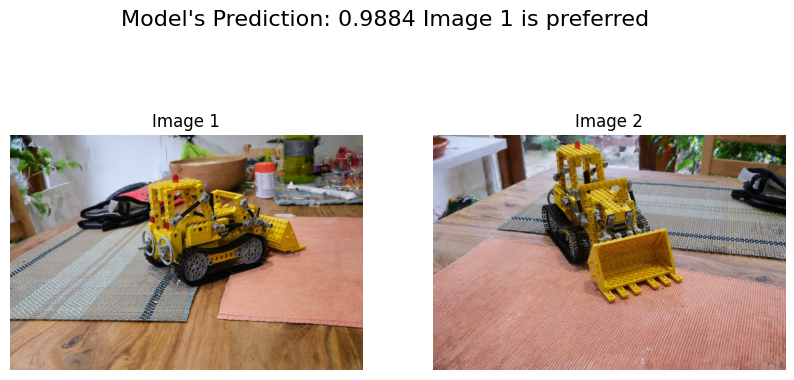

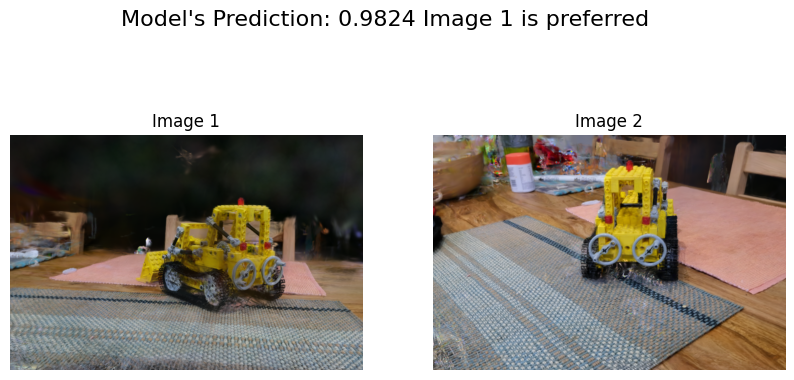

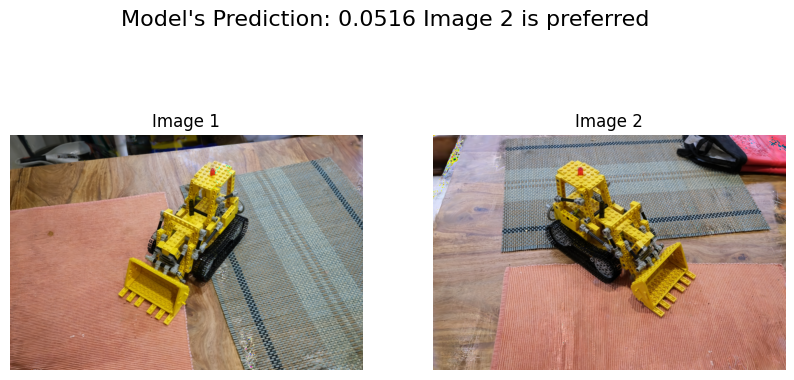

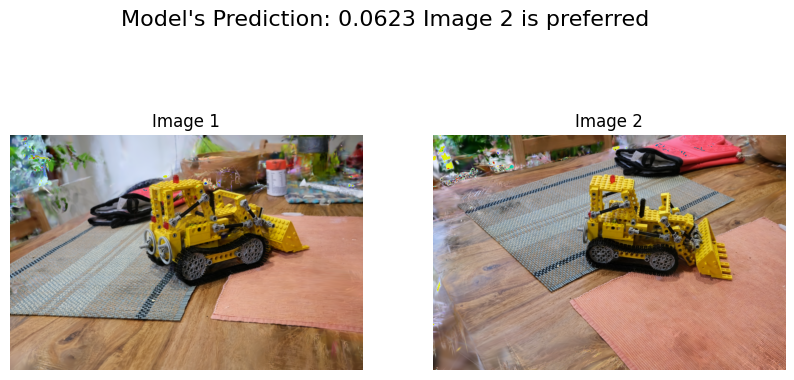

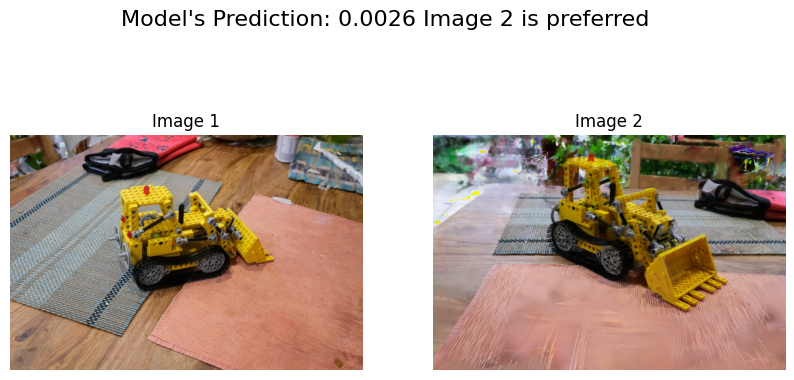

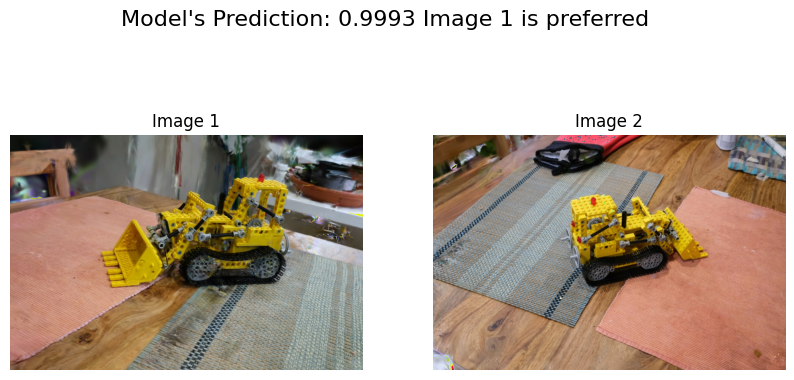

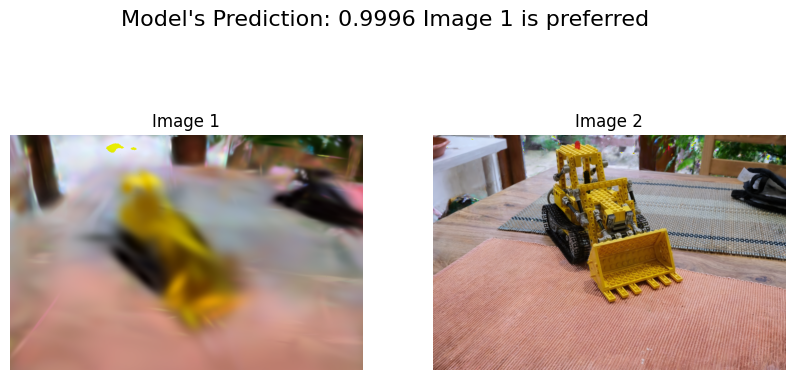

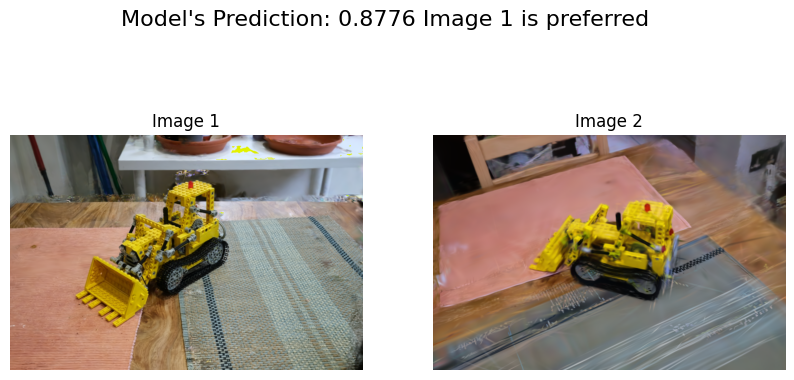

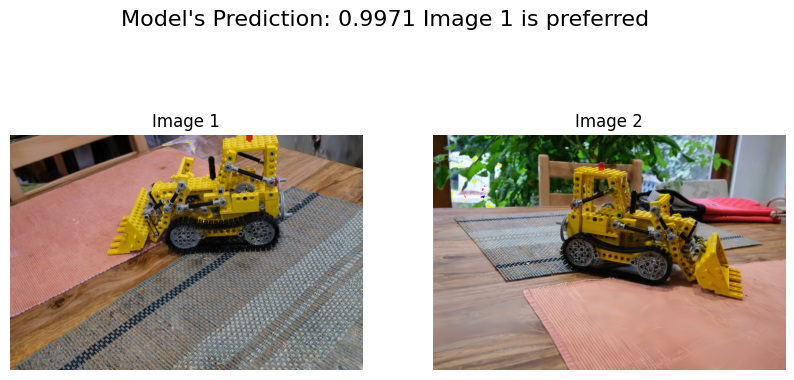

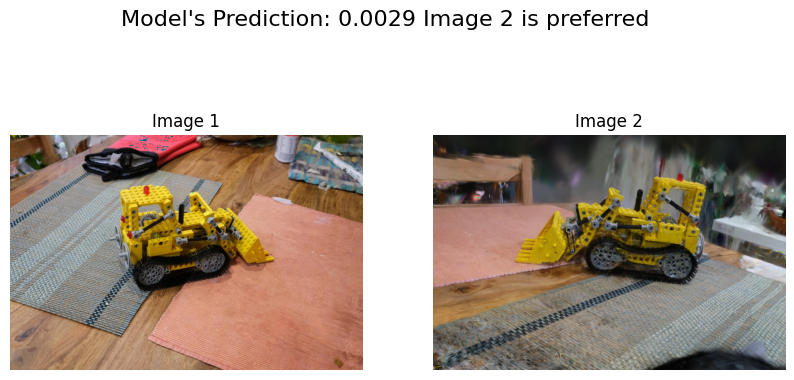

In [86]:
# Initialize and load the model
model = ResNetBinaryClassifier()
model.load_state_dict(torch.load("../models/resnet/kitchen_resnet.pth"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for concatenated input
])


visualize_predictions(
    model=model,
    dataset_folder="../kitchen_small_dataset",
    pairs_csv="../kitchen_small_dataset/kitchen_all_image_pairs.csv",
    transform= transform,
    num_samples=10
)